# Ensamble solutions

An ensemble classifier is a machine learning model that combines the predictions of multiple individual classifiers to improve the overall performance and accuracy of the classification task. It is used when the goal is to improve the performance of a single classifier, or when multiple classifiers have complementary strengths and weaknesses. In many cases it performs better but it is not a guarantee.

In this section some basic ensemble methods are analysed taking into account the best 3 and 5 models obtained in previous notebooks.

The models are ranked with the names:

1.   From_scatch: simple model with RmsProp (Notebook2 Experiment 1 )
2.   From_scatch deep_3_conv_layers (Notebook2 Experiment 2)
3.   Pre-Trained_fine_tuning_2_layers (Notebook3 Experiment 4)

4.   From_scatch Adam (Notebook2 Experiment 2 )
5.   From_scatch deep_3_conv_lay_relu6 (Notebook2 Experiment 2)



##Set parameters and load data

In [1]:
#Import all the required libraries

import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

from google.colab import drive

In [ ]:
# Mount drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set parameters

#Paths to get the splitted dataset
BASE_PATH='/content/drive/MyDrive/Vigna/'
DATASET_FOLDER_NAME='dataset'

NEW_PATH=os.path.join(BASE_PATH,DATASET_FOLDER_NAME)
NEW_PATH_TEST=os.path.join(NEW_PATH,'test')
MODEL_PATH=os.path.join(BASE_PATH,'models')

#Hyperparameters
BATCH_SIZE=32

In [ ]:
#Load data
test_dataset = image_dataset_from_directory(
    NEW_PATH_TEST,
    labels='inferred',
    shuffle=False,
    label_mode='categorical',
    image_size=(480, 640),
    #color_mode='grayscale',
    batch_size=BATCH_SIZE)

Found 675 files belonging to 9 classes.


In [ ]:
#Some utility functions

#Function to plot a custom barchar
def drawBarPlot(plt,name,values,title):
  plt.figure(figsize=(15, 5))
  plt.bar(name, values, width = 0.2, color='blue')
  plt.xlabel("Classes misclassified")
  plt.ylabel("No. of misclassification ")
  plt.title(title)
  plt.show()

#Function to have a brief summary of classification error on test dataset
def statErrors(test_dataset,predictions,verbose=False,displayImage=False):
  errorCount=0
  indexErr_List=[]
  
  #Iterate on all the test dataset
  test_val=tf.concat([data_batch for data_batch, labels_batch in test_dataset], axis = 0)
  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  

  class_names = test_dataset.class_names

  #Print the status of correct/incorrect predictions.
  if (verbose==True):
      print("predicted || actual");

  map={}
  for i in range (len(class_names)):
    map[class_names[i]]=0

  for indexTest in range(predictions.shape[0]):
      infoStr="";
      actual=class_names[np.argmax(y_test[indexTest])]
      predicted=class_names[np.argmax(predictions[indexTest])]
      if (np.argmax(predictions[indexTest])!=np.argmax(y_test[indexTest])):
          errorCount+=1;
          indexErr_List.append(indexTest)
          infoStr="ERROR ";
          classToMatch=class_names[np.argmax(y_test[indexTest])]
          if classToMatch in map:
            map[classToMatch]=map[classToMatch]+1
         
      if (verbose==True):
        print(str(indexTest)+") "+infoStr+" "+predicted+'||'+actual+": "+str((predictions[indexTest][np.argmax(predictions[indexTest])])*100)+"%");
 
  print ("Total errors :" +str(errorCount)+"/"+str(predictions.shape[0]));

  drawBarPlot(plt,map.keys(),map.values(),'Misclassifications per class')

  IMAGE_PER_RAW=6
  if (displayImage):
    plt.figure(figsize=(20, 10))
    class_names = test_dataset.class_names
    for i in range(len(indexErr_List)):
        index=indexErr_List[i]
        ax = plt.subplot(int(len(indexErr_List)/IMAGE_PER_RAW)+1, IMAGE_PER_RAW, i + 1)
        plt.imshow(test_val[index][:,:,0], cmap='gray')  
        
        #perc=round ( (predictions[index][np.argmax(predictions[index])])*100,2)
        #percStr=str(perc)+"%"

        plt.title("Pred. "+class_names[np.argmax(predictions[index])] ,  fontsize=10)
        plt.text(0,600, "Act. "+class_names[np.argmax(y_test[index])], fontSize=12,bbox=dict(facecolor='red', alpha=0.2));
        
        plt.axis("off")


#Plot the confusion matrix and the ROC curve
def evalutation_performance(test_dataset,predictions):

  y_test = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)  
  
  y_testEFF=np.argmax(y_test, axis=1)
  y_pred = np.argmax(predictions,axis=2)
  y_pred=y_pred.reshape((len(y_testEFF),))
  cm = confusion_matrix(y_testEFF, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)

  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title('Confusion Matrix');

  disp.plot(ax=ax,cmap=plt.cm.Blues,values_format='g')
  plt.show()



There is the necessity to distinguish which model is used to make a prediction (from scratch or pre-trained typology) because the first requires grey-scale images, tensors of shape (480,640,1) instead the second requires RGB images, tensors of shape (480,640,3), so a proper adaptation is implemented.

In [ ]:
#Load models

model1 = load_model(MODEL_PATH+"/firstCNNModel_1.h5") #  from_scratch_simple_model with Relu using Rmsprop
model2 = load_model(MODEL_PATH+"/secondCNNModel_2.h5")#  from_scratch_deeper_3_conv_layers with LeakyRelu using Adam 
model3 = load_model(MODEL_PATH+"/PreTrainedCNNModel_4.h5")# pre_traiend_fine_tuning_last_two_layers

model4 = load_model(MODEL_PATH+"/firstCNNModel_3.h5")#  from_scratch_simple_model with Relu using Adam
model5 = load_model(MODEL_PATH+"/secondCNNModel_3.h5")#  from_scratch_deeper_3_conv_layers with relu6 using Adam 


MODELS_3_MODELS=[model1,model2,model3]
MODELS_5_MODELS=[model1,model2,model4,model5]

FROM_SCRATCH_MODELS=[model1,model2,model4,model5]
PRE_TRAINED_MODELS=[model3]

In [ ]:
#Despite the batch size of 32, the samples are all loaded and stored in these variables.
test_val=tf.concat([data_batch for data_batch, labels_batch in test_dataset], axis = 0)
test_class=tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)

## General ensamble structure
The next method is a generic function used in all the next experiments to combine the scores obtained by a specific ensamble strategy on a set of data (test set). 


In [ ]:
#MODELS_TO_CONSIDER =list of trained models
#testDataset = the samples to be predicted
#test_class = the effective class of samples to be predicted
#strategy = the ensamble strategy for predicting class of test samples (see next)
#WEIGHTS = optionally a list of numbers representing the weight of each ensamble (see next)

def ensamble_predict(MODELS_TO_CONSIDER,testDataset,test_class,strategy,WEIGHTS=[]):
  ensemble_scores = []
  miss_class_counter=0
  
  for index in range(len(testDataset)):
    
      sample=testDataset[index]
   
      sample_grayScale=tf.image.rgb_to_grayscale(sample)  # Adapt to greyscale for pre-trained
      
      sample_grayScale=np.expand_dims(sample_grayScale,0)
      sample_norm=np.expand_dims(sample,0)
      
      if (strategy=='AVERAGE_STRATEGY'):
        ris=avarage_strategy(MODELS_TO_CONSIDER,sample_grayScale,sample_norm)
      
      elif (strategy =='WEIGHTED_AVERAGE_STRATEGY'):
        ris=weighted_avarage_strategy(MODELS_TO_CONSIDER,WEIGHTS,sample_grayScale,sample_norm)
      
      elif (strategy=='MAX_VOTING'):
        ris=max_voting(MODELS_TO_CONSIDER,sample_grayScale,sample_norm)
      
      #print("Predicted index:", index)
      if (np.argmax(ris)!=np.argmax(test_class[index])):
          miss_class_counter+=1;
     
      ensemble_scores.append(ris)
  
  print(" Miss class: "+ str(miss_class_counter)+"/"+str(len(testDataset)) + "  Accuracy: = {:.4f}".format( (len(testDataset)-miss_class_counter)/len(testDataset)) )
  return ensemble_scores

## Avarage strategy
This method is mainly used for regression problems. It consists of building multiple models independently and returning the average of the prediction of all the models. In general, the combined output is better than an individual output because variance is reduced. <br>
All the model considered in the ensamble has the same importants.

In [ ]:
def avarage_strategy(ENSAMBLE_MODELS,sample_grayScale,sample_norm):
    ris=np.zeros(shape=(1, 9))
    
    for model in ENSAMBLE_MODELS:
      if (model in FROM_SCRATCH_MODELS):
            prediction=model.predict(sample_grayScale,verbose='off')
      else:
            prediction=model.predict(sample_norm,verbose='off')
      ris=np.add(ris,prediction)
    
    ris=np.divide(ris, np.ones((1,9))*len(ENSAMBLE_MODELS))
    return ris

In [ ]:
predictions_3_Models=ensamble_predict(MODELS_3_MODELS,test_val,test_class,'AVERAGE_STRATEGY')

 Miss class: 7/675  Accuracy: = 0.9896


Total errors :7/675


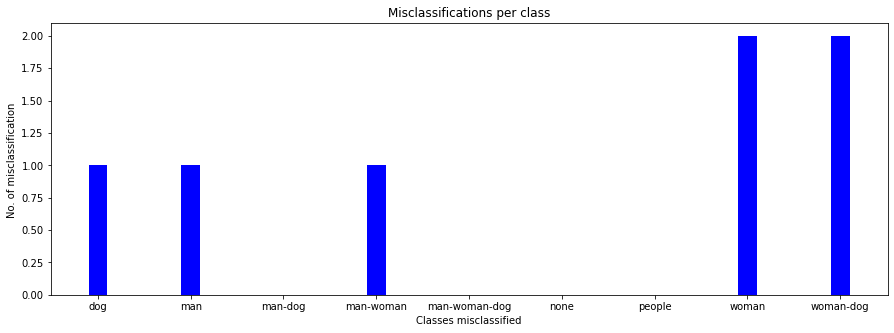

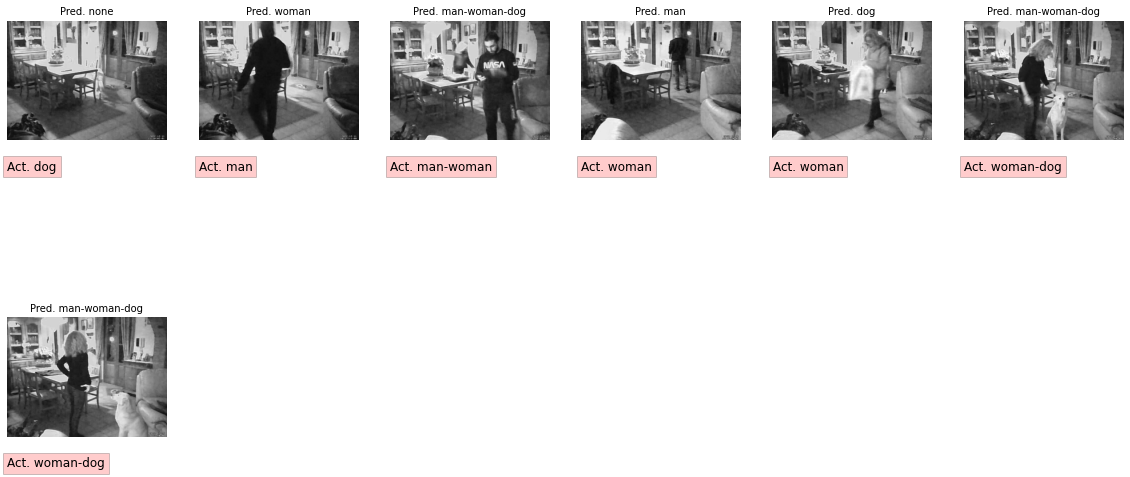

In [ ]:
statErrors(test_dataset,np.array(predictions_3_Models),False,True)

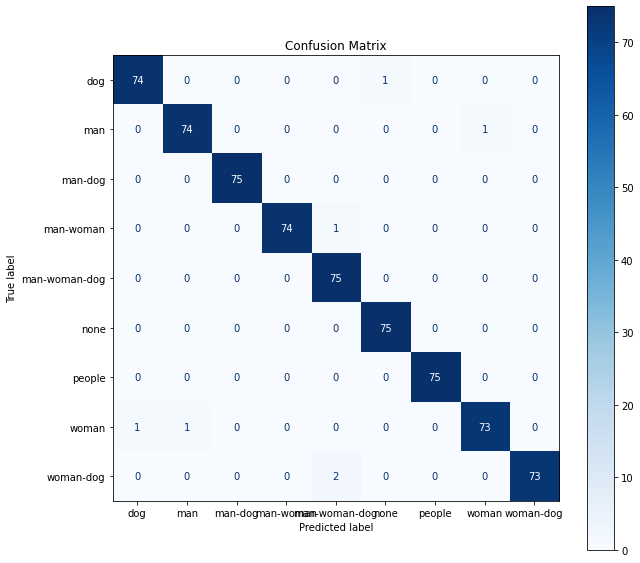

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_3_Models))

In [ ]:
predictions_5_Models=ensamble_predict(MODELS_5_MODELS,test_val,test_class,'AVERAGE_STRATEGY')

 Miss class: 10/675  Accuracy: = 0.9852


Total errors :10/675


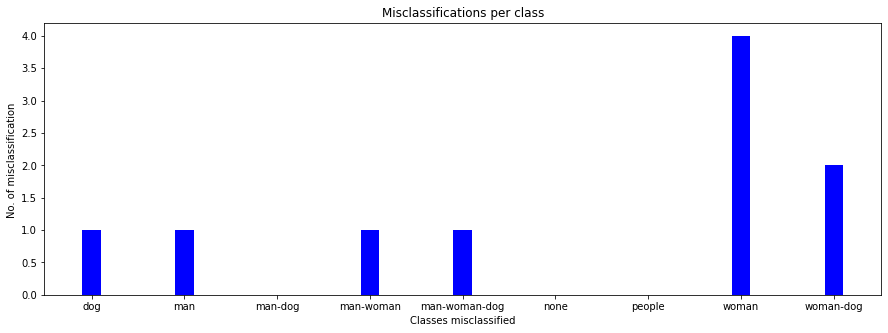

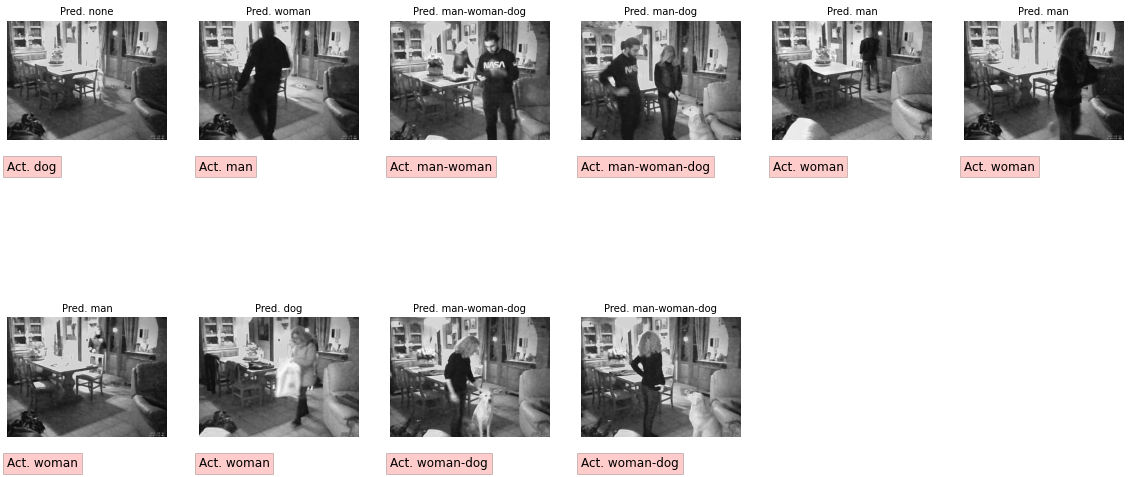

In [ ]:
statErrors(test_dataset,np.array(predictions_5_Models),False,True)

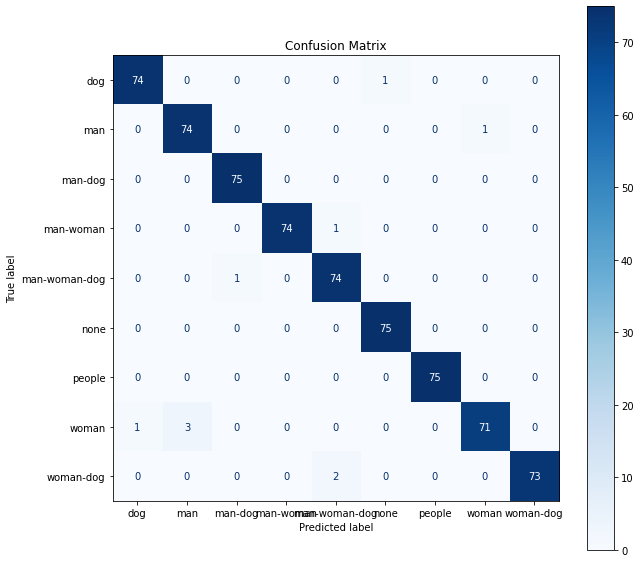

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_5_Models))

## Weighted Avarage

The second ensemble method considered is weighted average strategy. The logic is the same as averaging strategy but considering the prediction of each classifier with a different weight. This technique is most used in cases where different classifiers have different performances. The most performing will have a heavier weight respect to the less accurate.



In [ ]:
def weighted_avarage_strategy(ENSAMBLE_MODELS,WEIGHTS,sample_grayScale,sample_norm):
    
    ris=np.zeros(shape=(1, 9))
    
    for model in ENSAMBLE_MODELS:
      index=ENSAMBLE_MODELS.index(model)
      if (model in FROM_SCRATCH_MODELS):
            prediction=model.predict(sample_grayScale,verbose='off')
      else:
            prediction=model.predict(sample_norm,verbose='off')
      
      ris=np.add(ris,prediction*WEIGHTS[index])
    
    ris=np.divide(ris, np.ones((1,9))*np.sum(WEIGHTS))
    return ris

In [ ]:
WEIGHTS=[0.35,0.40,0.25]

In [ ]:
predictions_3_Models=ensamble_predict(MODELS_3_MODELS,test_val,test_class,'WEIGHTED_AVERAGE_STRATEGY',WEIGHTS)

 Miss class: 7/675  Accuracy: = 0.9896


Total errors :7/675


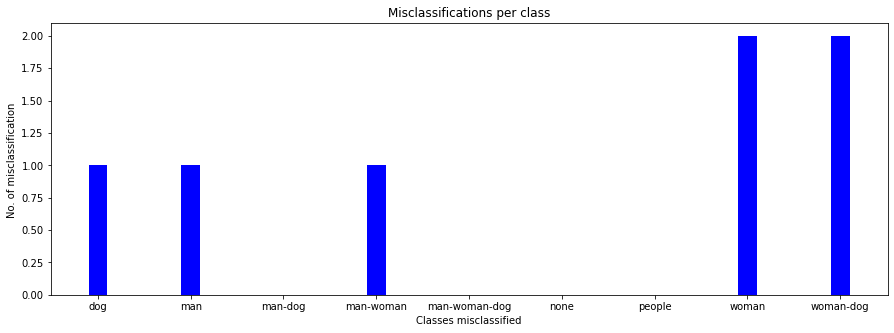

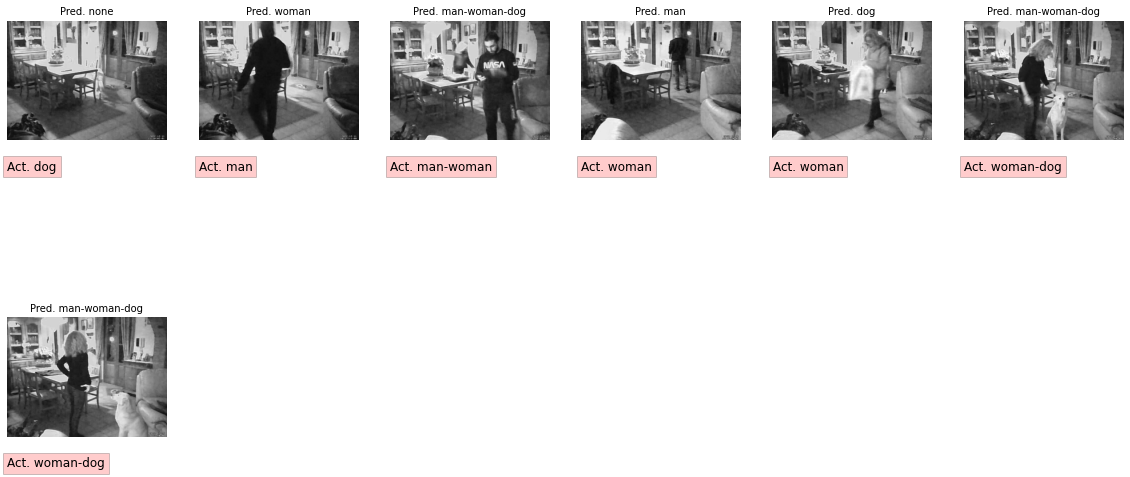

In [ ]:
statErrors(test_dataset,np.array(predictions_3_Models),False,True)

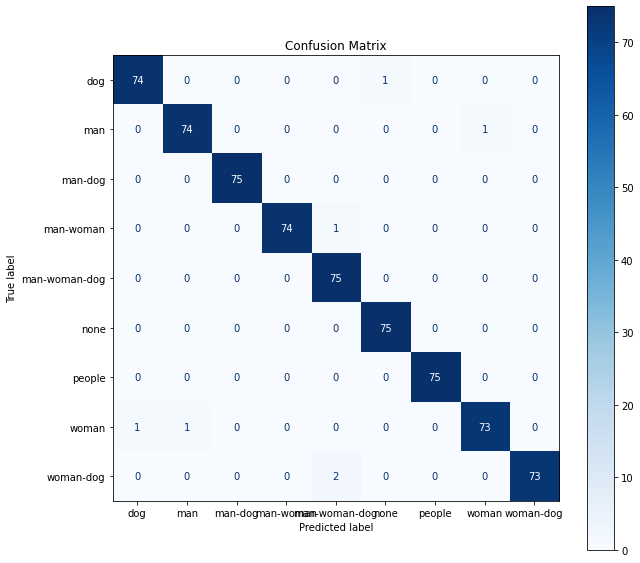

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_3_Models))

Using 5 models the first 3 models has more relevance respect to the last 2

In [ ]:
WEIGHTS=[0.25,0.25,0.25,0.125,0.125]

In [ ]:
predictions_5_Models=ensamble_predict(MODELS_5_MODELS,test_val,test_class,'WEIGHTED_AVERAGE_STRATEGY',WEIGHTS)

 Miss class: 9/675  Accuracy: = 0.9867


Total errors :9/675


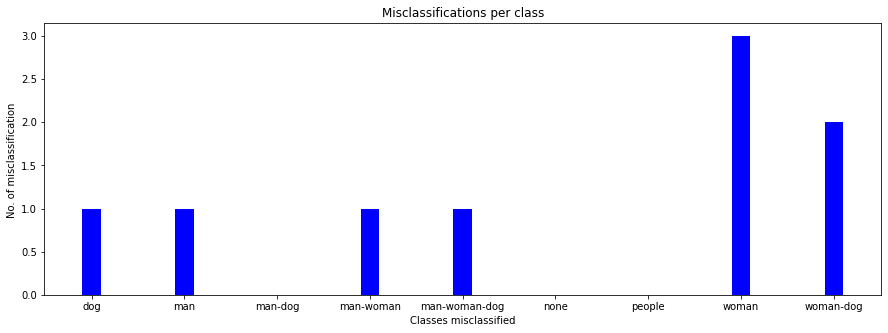

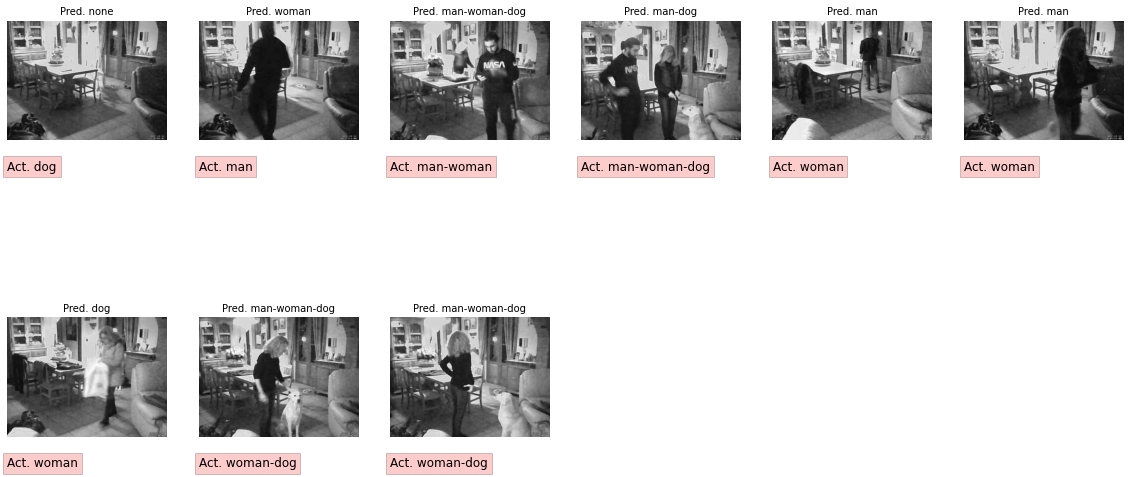

In [ ]:
statErrors(test_dataset,np.array(predictions_5_Models),False,True)

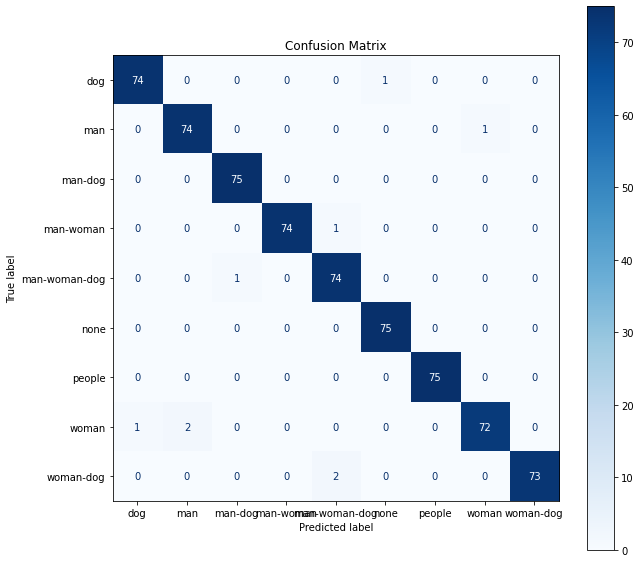

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_5_Models))

Using 5 models with a diffrent combination of weights:

In [ ]:
WEIGHTS=[0.05,0.15,0.20,0.30,0.35]

In [ ]:
predictions_5_Models=ensamble_predict(MODELS_5_MODELS,test_val,test_class,'WEIGHTED_AVERAGE_STRATEGY',WEIGHTS)

 Miss class: 10/675  Accuracy: = 0.9852


Total errors :10/675


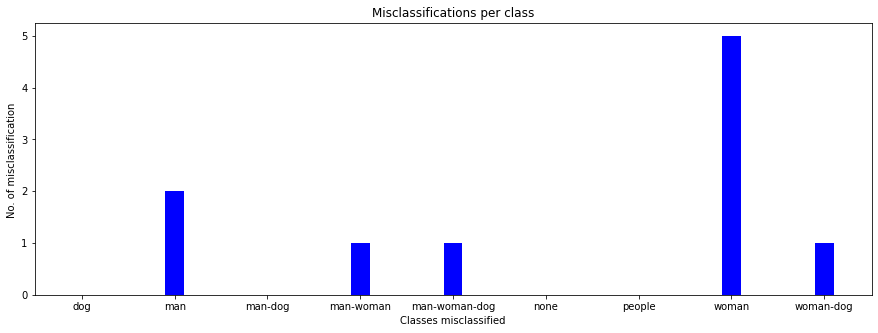

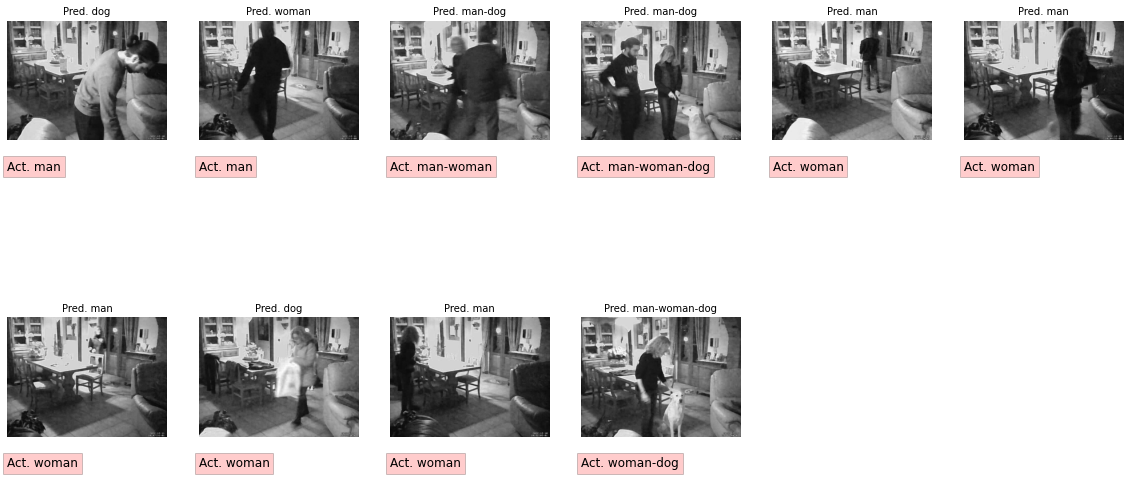

In [ ]:
statErrors(test_dataset,np.array(predictions_5_Models),False,True)

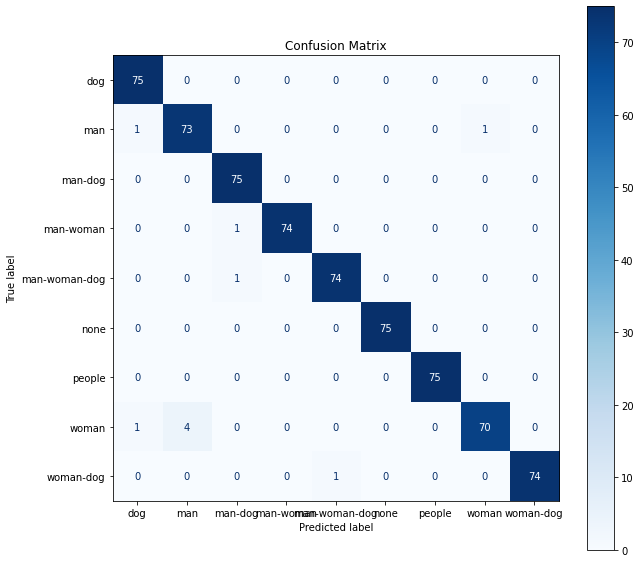

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_5_Models))

## Max-Voting
The third and last ensemble method considered is max-voting strategy. This is generally used for classification problems and it is one of the simplest ways of combining predictions from multiple learning algorithms. In max-voting, each base model makes a prediction and votes for each sample. Only the sample class with the highest votes is included in the final predictive class.

In [ ]:
def max_voting(ENSAMBLE_MODELS,sample_grayScale,sample_norm):

    voting_score=np.zeros(shape=(1, 9))

    for model in ENSAMBLE_MODELS:
      if (model in FROM_SCRATCH_MODELS):
            prediction=model.predict(sample_grayScale,verbose='off')
      else:
            prediction=model.predict(sample_norm,verbose='off')

      voting_score[0][np.argmax(prediction)]+=1
      
    ris=np.zeros(shape=(1, 9))
    ris[0][np.argmax(voting_score)]+=1

    return ris

#Not considered:
#This is an alternative way to use max_voting, giving a different weight to each
#final vote (when the class is finally predicted "np.argmax(prediction)")
def weighted_voting(ENSAMBLE_MODELS,WEIGHTS,sample_grayScale,sample_norm):

    voting_score=np.zeros(shape=(1, 9))

    for model in ENSAMBLE_MODELS:
      index=ENSAMBLE_MODELS.index(model)
      if (model in FROM_SCRATCH_MODELS):
            prediction=model.predict(sample_grayScale,verbose='off')
      else:
            prediction=model.predict(sample_norm,verbose='off')

      voting_score[0][np.argmax(prediction)]+=(1*WEIGHTS[index])
      print(prediction)
      print(index)
      print(voting_score)

    ris=np.zeros(shape=(1, 9))
    ris[0][np.argmax(voting_score)]+=1

    return ris

In [ ]:
predictions_3_Models=ensamble_predict(MODELS_3_MODELS,test_val,test_class,'MAX_VOTING')

 Miss class: 9/675  Accuracy: = 0.9867


Total errors :9/675


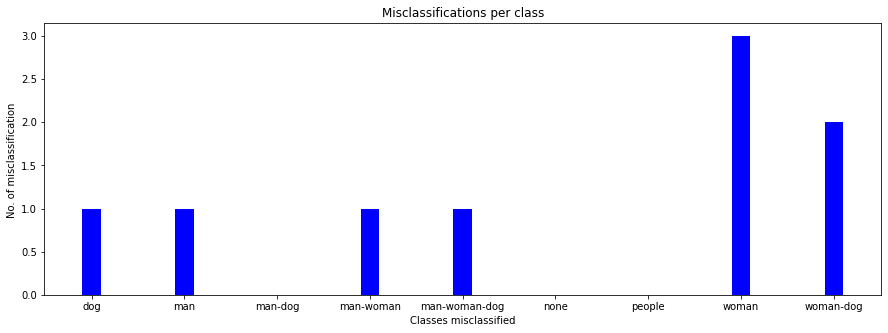

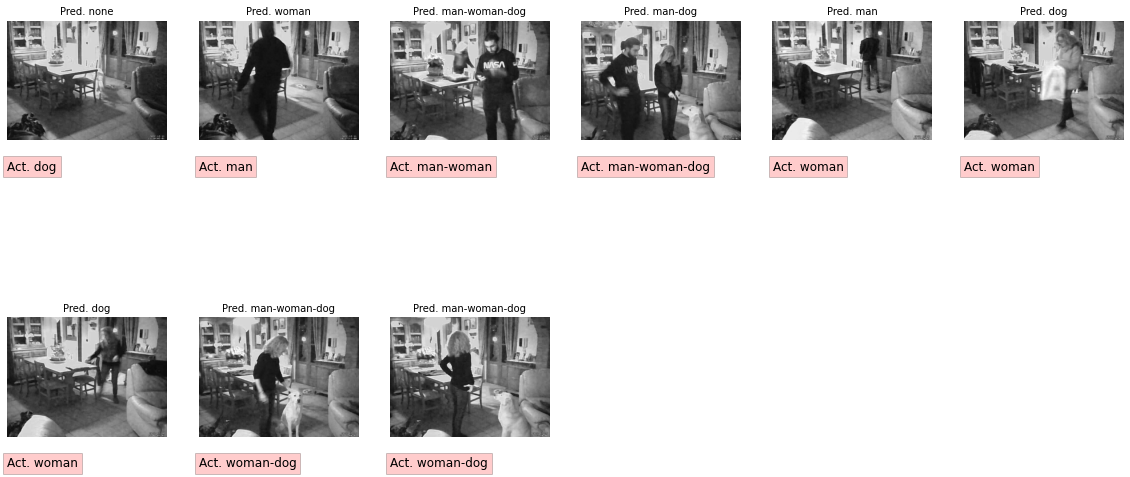

In [ ]:
statErrors(test_dataset,np.array(predictions_3_Models),False,True)

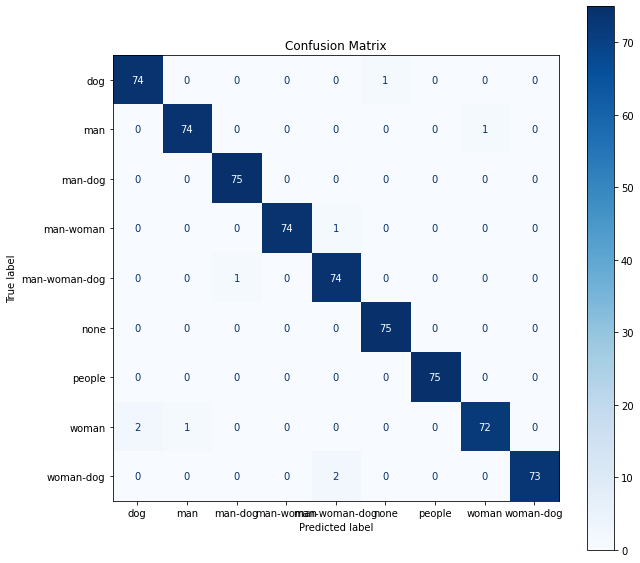

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_3_Models))

In [ ]:
predictions_5_Models=ensamble_predict(MODELS_5_MODELS,test_val,test_class,'MAX_VOTING')

 Miss class: 12/675  Accuracy: = 0.9822


Total errors :12/675


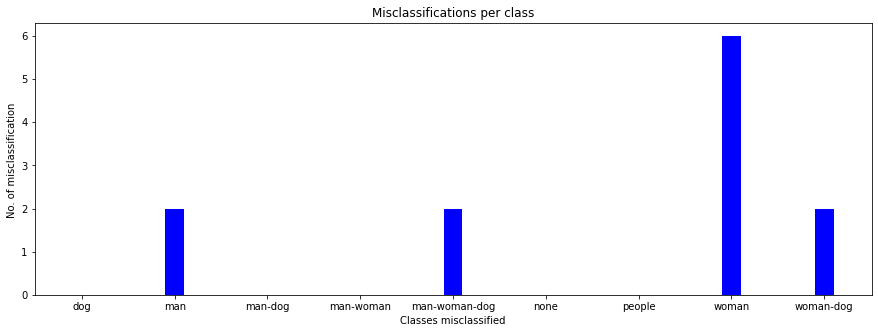

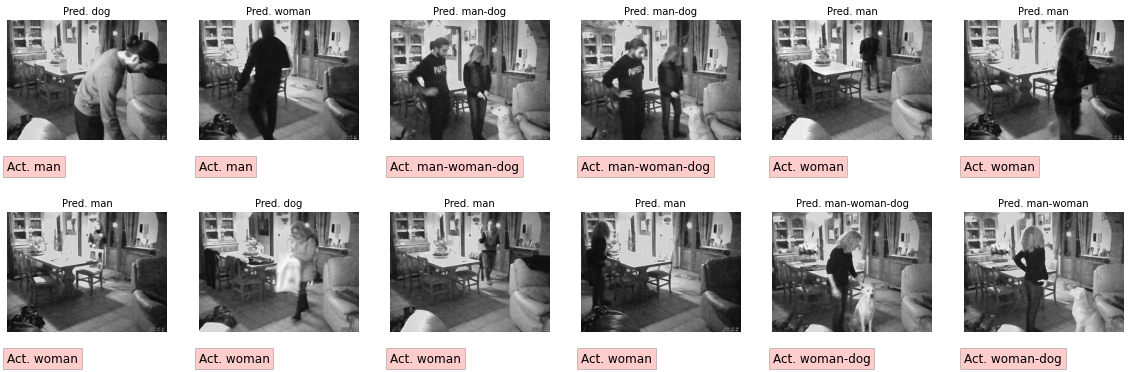

In [ ]:
statErrors(test_dataset,np.array(predictions_5_Models),False,True)

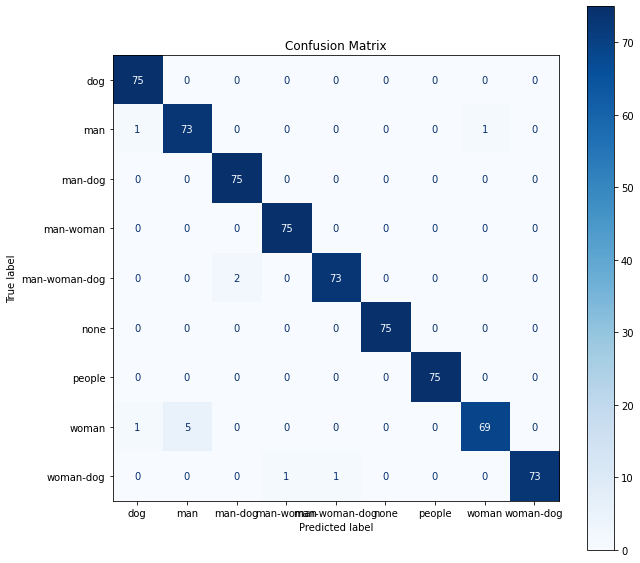

In [ ]:
evalutation_performance(test_dataset,np.array(predictions_5_Models))